<a href="https://colab.research.google.com/github/SamNgigi/Deep-lLearning-Manenoz/blob/master/TrafficSign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensor Play

Experimenting with the tensor flow gpu environment.

In [50]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [7]:
"""
Bench-marking CPU vs GPU
"""

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100,100,100,3))
    net_cpu =  tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print(f'GPU speedup over CPU: {int(cpu_time/gpu_time)}x')

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.4015807960000757
GPU (s):
0.051797002000057546
GPU speedup over CPU: 65x


PyTorch Tensor

Numpy based operations are not optimized to utilize GPUs to accelerate its numerical computations. 

For mordern deep neural networks GPUs often provides speed ups of 50x or greater so unfortunately numpy isn't enough for modern deep learning. 

PyTorch introduces the **Tensor** concept that is conceptuallyl identical to an n-dimensional numpy array but can utilize GPUs to accelerate their numeric computations.

Lets explore them

In [0]:
import torch, numpy
import matplotlib.pyplot as plt

In [11]:
# The defaul tensor type in PyTorch is a float tensor - torch.FloatTensor
x = torch.ones(3,2)
y = torch.zeros(3,2)
print(x)
print(y)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])


In [13]:
# To increase reproducibility, we oftern set the random seed to specific value first
torch.manual_seed(2)
x=torch.rand(3, 2)
print(x)
x=torch.randn(3, 3) # for a tensor with normally distributed random values
print(x)

tensor([[0.6147, 0.3810],
        [0.6371, 0.4745],
        [0.7136, 0.6190]])
tensor([[-2.1409, -0.5534, -0.5000],
        [-0.0815, -0.1633,  1.5277],
        [-0.4023,  0.0972, -0.5682]])


In [14]:
# Getting the data onto Colab
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [15]:
# 
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


An alternative approach to loading the data. Here we use the kaggle api to load data directly into colab

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Installing Kaggle Library
!pip install -q kaggle

In [56]:
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [0]:
!mv kaggle.json /root/.kaggle/

In [59]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 96% 589M/612M [00:07<00:00, 65.0MB/s]
100% 612M/612M [00:07<00:00, 86.0MB/s]


In [60]:
# Checking the contents of the current directory. Note the german traffic zip
!ls .

 german-traffic-signs		'kaggle (1).json'
 gtsrb-german-traffic-sign.zip	 sample_data


In [0]:
# Importing Libraries
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [0]:
# For reproducability
np.random.seed(0)

We create the function below to help load the images from their pickle format

In [66]:
def pickle_dataLoader(data_set, columns):
  with open(f'german-traffic-signs/{data_set}', 'rb') as data:
    imgs = pickle.load(data)
  return tuple(map(lambda x: imgs[x], columns))

data_cols = ['features', 'labels']

X_train, Y_train = pickle_dataLoader('train.p', data_cols)
X_val, Y_val = pickle_dataLoader('valid.p', data_cols)
X_test, Y_test = pickle_dataLoader('test.p', data_cols)


print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


In [25]:
# Getting the signnames
data = pd.read_csv('german-traffic-signs/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


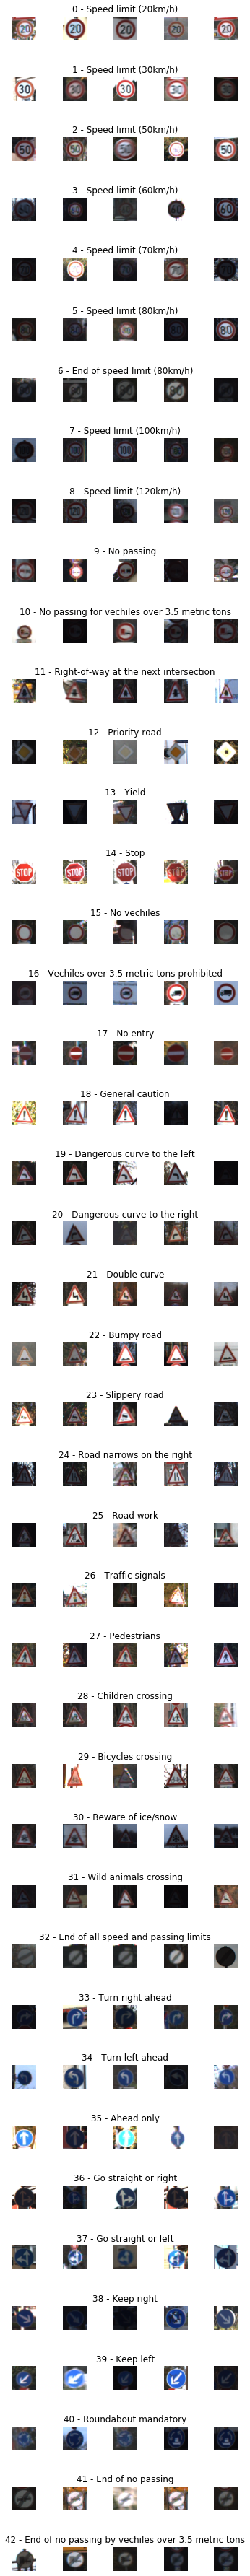

In [67]:
num_of_samples = []

cols = 5
num_classes = data.shape[0] # 43 classes for this classification

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):

  for j, row in data.iterrows():
    x_selected = X_train[Y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :],
                     cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

In [48]:
x_train[y_train == 0].shape

(180, 32, 32, 3)

In [38]:
tst = pd.DataFrame([[1, 1.5], [2, 2.5]], columns=['int', 'float'])
next(tst.iterrows())

(0, int      1.0
 float    1.5
 Name: 0, dtype: float64)

In [42]:
next(tst.iterrows())[0]

0

In [45]:
for i, j in tst.iterrows():
  print(j)

0
1


TypeError: ignored